# Dimensionality reduction 

Dimensionality reduction (t-SNE and UMAP) on track spline data and visualizes the resulting 2D embeddings. The points in the plots are colored based on associated track performance metrics **extracted directly from the 'fitness' key within the track JSON files.**

In [50]:
import pandas as pd
from pathlib import Path
import json
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.spatial.distance import cdist 
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.impute import SimpleImputer

DATA_DIRECTORY = Path('./voronoi') # <<< SET YOUR PATH HERE
TECHNIQUE_NAME = 'voronoi'
# Dimensionality Reduction Parameters
TSNE_RANDOM_STATE = 42
UMAP_RANDOM_STATE = 42
IMPUTATION_STRATEGY = 'mean' # How to handle potential NaNs in spline coords ('mean', 'median')

def parse_seed_from_filename(filename_path: Path) -> int | None:
    """
    Parses a numeric seed ID from the beginning of a filename stem.
    Example: "123_data.json" -> 123, "456.json" -> 456.
    Returns the integer seed or None if parsing fails.
    """
    base_filename = filename_path.stem
    parts = base_filename.split('_')
    if not parts:
        return None
    try:
        seed = int(parts[0])
        return seed
    except (ValueError, IndexError):
        return None


def load_unique_seed_spline_and_fitness_data(data_directory: Path, technique_name: str):
    """
    Loads flattened spline vectors AND fitness data for unique seeds from a directory.

    Processes the first valid JSON file found for each seed ID.
    Validates spline data format and ensures 'fitness' key exists and is a dictionary.

    Returns:
        Tuple: (feature_vectors, track_seeds, original_splines_map, fitness_data_map, expected_vector_length)
               Returns empty structures and None for length on error or no valid files.
    """
    feature_vectors = []
    track_seeds = []
    original_splines_map = {}
    fitness_data_map = {} # <<< Store fitness data here {seed: fitness_dict}
    expected_vector_length = None
    processed_seeds = set()

    if not data_directory.is_dir():
        print(f"Error: Data directory not found: '{data_directory}'", file=sys.stderr)
        return np.array([]).reshape(0, 0), [], {}, {}, None

    print(f"\n--- Loading unique spline and fitness data for '{technique_name}' from '{data_directory}' ---")
    sorted_files = sorted(list(data_directory.glob('*.json')))
    files_found = len(sorted_files)
    print(f"Found {files_found} JSON files.")

    # Counters for summary
    processed_file_count = 0
    valid_entries_loaded = 0
    skipped_parsing = 0
    skipped_duplicate = 0
    skipped_invalid_spline = 0
    skipped_missing_fitness = 0
    skipped_length_mismatch = 0
    skipped_read_error = 0

    for file_path in sorted_files:
        seed = parse_seed_from_filename(file_path)
        if seed is None:
            skipped_parsing += 1
            continue

        if seed in processed_seeds:
            skipped_duplicate += 1
            continue

        processed_file_count += 1
        try:
            with file_path.open('r', encoding='utf-8') as f:
                data = json.load(f)

            # --- Validate Spline Data ---
            spline_data_raw = data.get('splineVector')
            if not isinstance(spline_data_raw, list) or not spline_data_raw:
                skipped_invalid_spline += 1
                continue

            current_feature_vector = []
            is_valid_spline = True
            for point in spline_data_raw:
                if isinstance(point, dict):
                    x, y = point.get('x'), point.get('y')
                    if isinstance(x, (int, float)) and isinstance(y, (int, float)):
                        current_feature_vector.extend([float(x), float(y)])
                    else: is_valid_spline = False; break
                else: is_valid_spline = False; break

            if not is_valid_spline:
                skipped_invalid_spline += 1
                continue

            current_vector_length = len(current_feature_vector)
            if current_vector_length == 0:
                skipped_invalid_spline += 1
                continue

            # --- Validate Fitness Data ---
            fitness_data = data.get('fitness')
            if not isinstance(fitness_data, dict):
                 print(f"Warning: Skipping '{file_path.name}' (Seed {seed}). Missing or invalid 'fitness' dictionary.", file=sys.stderr)
                 skipped_missing_fitness += 1
                 continue # Skip if fitness data is missing/invalid

            # --- Check Length and Store ---
            if expected_vector_length is None:
                expected_vector_length = current_vector_length
                print(f"Determined expected spline vector length: {expected_vector_length} (from '{file_path.name}')")

            if current_vector_length == expected_vector_length:
                # Store all valid data for this seed
                feature_vectors.append(current_feature_vector)
                track_seeds.append(seed)
                original_splines_map[seed] = spline_data_raw
                fitness_data_map[seed] = fitness_data # Store fitness dict
                processed_seeds.add(seed)
                valid_entries_loaded += 1
            else:
                skipped_length_mismatch += 1

        except (json.JSONDecodeError, IOError) as e:
            print(f"Warning: Error reading/decoding '{file_path.name}' (Seed {seed}): {e}. Skipping.", file=sys.stderr)
            skipped_read_error += 1
        except Exception as e:
             print(f"Warning: Unexpected error processing '{file_path.name}' for seed {seed}: {e}. Skipping.", file=sys.stderr)
             skipped_read_error += 1

    # --- Loading Summary ---
    print("\nData Loading Summary:")
    print(f"- Files found: {files_found}")
    print(f"- Files processed (attempted read): {processed_file_count}")
    print(f"- Valid unique entries loaded (Spline + Fitness): {valid_entries_loaded}")
    print(f"- Files skipped:")
    print(f"  - Could not parse seed: {skipped_parsing}")
    print(f"  - Duplicate seed: {skipped_duplicate}")
    print(f"  - Invalid/empty spline data: {skipped_invalid_spline}")
    print(f"  - Missing/invalid fitness data: {skipped_missing_fitness}")
    print(f"  - Spline vector length mismatch: {skipped_length_mismatch}")
    print(f"  - File read/decode error: {skipped_read_error}")

    if valid_entries_loaded == 0:
         print(f"\nNo valid unique entries loaded. Cannot proceed.")
         final_shape = (0, expected_vector_length if expected_vector_length else 0)
         return np.array([]).reshape(final_shape), [], {}, {}, expected_vector_length
    else:
        print(f"\nProceeding with {valid_entries_loaded} unique entries.")
        # Return fitness map as well
        return np.array(feature_vectors, dtype=float), track_seeds, original_splines_map, fitness_data_map, expected_vector_length


In [51]:
def plot_embedding_colored_by_metric(
    embedding_df: pd.DataFrame,
    x_col: str, y_col: str, metric_col: str,
    technique_name: str, embedding_type: str
    ):
    """Plots a 2D embedding, coloring points by a specified metric column."""
    required_cols = [x_col, y_col, metric_col, 'seed']
    if embedding_df is None or embedding_df.empty:
        print(f"Skipping {embedding_type} plot for '{metric_col}': Input DataFrame is empty.", file=sys.stderr)
        return
    # Check if the specific metric_col exists before proceeding with plotting logic
    if not all(col in embedding_df.columns for col in required_cols):
        missing = [col for col in required_cols if col not in embedding_df.columns]
        print(f"Skipping {embedding_type} plot for '{metric_col}': DataFrame missing columns: {missing}.", file=sys.stderr)
        return

    x_coords, y_coords = embedding_df[x_col], embedding_df[y_col]
    metric_values = embedding_df[metric_col]
    nan_mask = metric_values.isna()
    valid_mask = ~nan_mask
    num_nan, num_valid = nan_mask.sum(), valid_mask.sum()

    plt.figure(figsize=(8, 6.5))
    cmap = plt.cm.viridis
    plot_title = f"{embedding_type} Embedding ({technique_name})\nColored by {metric_col.replace('_', ' ').title()}"
    plot_subtitle = ""

    if num_valid > 0:
        # Handle potential non-numeric data in metric column gracefully for normalization
        numeric_metric_values = pd.to_numeric(metric_values[valid_mask], errors='coerce')
        valid_numeric_mask = ~numeric_metric_values.isna()
        if valid_numeric_mask.sum() > 0:
            vmin = numeric_metric_values[valid_numeric_mask].min()
            vmax = numeric_metric_values[valid_numeric_mask].max()
            norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

            scatter = plt.scatter(x_coords[valid_mask][valid_numeric_mask], y_coords[valid_mask][valid_numeric_mask],
                                  c=numeric_metric_values[valid_numeric_mask],
                                  cmap=cmap, norm=norm, s=35, alpha=0.85, edgecolor='k', linewidth=0.5)
            plt.colorbar(scatter, label=metric_col.replace('_', ' ').title())
        else:
            plot_subtitle = f"(No numeric data for '{metric_col}')" # All valid points were non-numeric

    # Add count of non-numeric points excluded from coloring
    non_numeric_excluded = num_valid - valid_numeric_mask.sum() if num_valid > 0 else 0
    if non_numeric_excluded > 0:
        plot_subtitle += f" ({non_numeric_excluded} non-numeric points ignored)"

    if num_valid == 0 and non_numeric_excluded == 0: # Only if truly no valid data at all
         plot_subtitle = f"(No valid data for '{metric_col}')"

    if num_nan > 0:
        plt.scatter(x_coords[nan_mask], y_coords[nan_mask], color='lightgrey',
                    s=35, alpha=0.6, edgecolor='grey', linewidth=0.5, label=f'NaN Value ({num_nan} points)')
        plt.legend(loc='best', fontsize=8)
        if num_valid > 0 or non_numeric_excluded > 0: # Add context if other points exist
             plot_subtitle += f" ({num_nan} NaN points)"

    plt.title(f"{plot_title}\n{plot_subtitle}".strip(), fontsize=12)
    plt.xlabel(f"{embedding_type} Dimension 1", fontsize=10)
    plt.ylabel(f"{embedding_type} Dimension 2", fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()


## Load Track Spline and Fitness Data

In [52]:
raw_spline_features, track_seeds, original_splines_map, fitness_data_map, vector_length = \
    load_unique_seed_spline_and_fitness_data(DATA_DIRECTORY, TECHNIQUE_NAME)

# Store original splines map globally if needed later
global_original_splines = original_splines_map if track_seeds else {}

# %% [markdown]
# ## Prepare Features for Embedding

# %%
imputed_spline_features = None

# Proceed only if spline data was loaded successfully
if raw_spline_features is not None and raw_spline_features.size > 0:
    # Handle potential NaNs in coordinate values via Imputation
    nan_count = np.isnan(raw_spline_features).sum()
    if nan_count > 0:
        print(f"\nFound {nan_count} NaNs in flattened spline vectors. Imputing using '{IMPUTATION_STRATEGY}' strategy...")
        try:
            imputer = SimpleImputer(strategy=IMPUTATION_STRATEGY)
            imputed_spline_features = imputer.fit_transform(raw_spline_features)
            print("Imputation complete.")
        except Exception as e:
            print(f"Error during imputation: {e}. Cannot proceed with embeddings.", file=sys.stderr)
            # Keep imputed_spline_features as None
    else:
        imputed_spline_features = raw_spline_features # No NaNs
        print("\nNo NaNs found in flattened spline vectors. No imputation needed.")
else:
     print("\nSkipping feature preparation: No spline data loaded.")


--- Loading unique spline and fitness data for 'voronoi' from 'voronoi' ---
Found 2000 JSON files.
Determined expected spline vector length: 200 (from '0.json')

Data Loading Summary:
- Files found: 2000
- Files processed (attempted read): 2000
- Valid unique entries loaded (Spline + Fitness): 1942
- Files skipped:
  - Could not parse seed: 0
  - Duplicate seed: 0
  - Invalid/empty spline data: 58
  - Missing/invalid fitness data: 0
  - Spline vector length mismatch: 0
  - File read/decode error: 0

Proceeding with 1942 unique entries.

No NaNs found in flattened spline vectors. No imputation needed.


In [53]:

tsne_embedding = None
umap_embedding = None
df_embeddings = pd.DataFrame() # Initialize empty DataFrame

if imputed_spline_features is not None:
    print(f"\nInput feature shape for embeddings: {imputed_spline_features.shape}")
    # Ensure track_seeds is consistent with the features used for embedding
    if len(track_seeds) == imputed_spline_features.shape[0]:
        df_embeddings = pd.DataFrame({'seed': track_seeds}) # Start with seeds
    else:
        print(f"Error: Mismatch between number of track seeds ({len(track_seeds)}) and feature rows ({imputed_spline_features.shape[0]}). Cannot create embeddings DataFrame.", file=sys.stderr)
        imputed_spline_features = None # Prevent further embedding calculation

if imputed_spline_features is not None:
    # --- t-SNE Calculation ---
    print("\n--- Applying t-SNE ---")
    try:
        tsne = TSNE(n_components=2, random_state=TSNE_RANDOM_STATE,
                    init='pca', learning_rate='auto', max_iter=1000, n_jobs=-1)
        print("Fitting t-SNE...")
        tsne_embedding = tsne.fit_transform(imputed_spline_features)
        print(f"t-SNE fitting complete. Output shape: {tsne_embedding.shape}")

        if tsne_embedding.shape[0] == len(track_seeds):
            df_embeddings['tsne_dim1'] = tsne_embedding[:, 0]
            df_embeddings['tsne_dim2'] = tsne_embedding[:, 1]
            print("Added t-SNE coordinates to DataFrame.")
        else:
            print("Error: t-SNE output rows mismatch number of tracks!", file=sys.stderr)
            tsne_embedding = None
    except Exception as e:
        print(f"Error during t-SNE calculation: {e}", file=sys.stderr)
        tsne_embedding = None

    # --- UMAP Calculation ---
    if umap is not None:
        print("\n--- Applying UMAP ---")
        try:
            reducer = umap.UMAP(n_components=2, random_state=UMAP_RANDOM_STATE,
                                n_neighbors=15, min_dist=0.1)
            print("Fitting UMAP...")
            umap_embedding = reducer.fit_transform(imputed_spline_features)
            print(f"UMAP fitting complete. Output shape: {umap_embedding.shape}")

            if umap_embedding.shape[0] == len(track_seeds):
                df_embeddings['umap_dim1'] = umap_embedding[:, 0]
                df_embeddings['umap_dim2'] = umap_embedding[:, 1]
                print("Added UMAP coordinates to DataFrame.")
            else:
                print("Error: UMAP output rows mismatch number of tracks!", file=sys.stderr)
                umap_embedding = None
        except Exception as e:
            print(f"Error during UMAP calculation: {e}", file=sys.stderr)
            umap_embedding = None
    else:
        print("UMAP library not available, skipping UMAP calculation.")
else:
    print("\nSkipping embedding calculation: No valid spline features available.")



Input feature shape for embeddings: (1942, 200)

--- Applying t-SNE ---
Fitting t-SNE...
t-SNE fitting complete. Output shape: (1942, 2)
Added t-SNE coordinates to DataFrame.

--- Applying UMAP ---
Fitting UMAP...


c:\Users\batman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\batman\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP fitting complete. Output shape: (1942, 2)
Added UMAP coordinates to DataFrame.


In [54]:

df_embeddings_with_metrics = pd.DataFrame() # Initialize final DataFrame
df_fitness_from_json = pd.DataFrame()      # Initialize fitness DataFrame

# Create DataFrame from the fitness data loaded from JSONs
if fitness_data_map:
    print("\n--- Preparing fitness data loaded from JSON files ---")
    try:
        # Create a list of dictionaries, adding 'seed' to each fitness dict
        fitness_records = [{'seed': seed, **fdata} for seed, fdata in fitness_data_map.items() if isinstance(fdata, dict)]
        if fitness_records:
            df_fitness_from_json = pd.DataFrame(fitness_records)
            print(f"Created DataFrame from JSON fitness data. Shape: {df_fitness_from_json.shape}")
            # Optional: Check for duplicate seeds coming from the map (shouldn't happen if loading logic is correct)
            if df_fitness_from_json['seed'].duplicated().any():
                 print("Warning: Duplicate seeds found after creating DataFrame from fitness map.", file=sys.stderr)
        else:
            print("No valid fitness records found in the loaded data.")
    except Exception as e:
        print(f"Error creating DataFrame from fitness data: {e}", file=sys.stderr)
        df_fitness_from_json = pd.DataFrame() # Ensure it's empty on error
else:
    print("\nNo fitness data was loaded from JSON files.")

if not df_embeddings.empty and not df_fitness_from_json.empty:
    print("\n--- Merging embedding coordinates with JSON fitness data ---")
    try:
        # Perform a left merge to keep all tracks that have embeddings
        df_embeddings_with_metrics = pd.merge(
            df_embeddings,
            df_fitness_from_json,
            on='seed',
            how='left' # Keep all rows from df_embeddings
        )
        print(f"Merge complete. Final DataFrame shape: {df_embeddings_with_metrics.shape}")

        # Verification: Check for rows in df_embeddings that didn't find a match in fitness data
        # (This indicates seeds that had spline data but no/invalid fitness data in their JSON)
        merged_rows = len(df_embeddings_with_metrics)
        initial_embedding_rows = len(df_embeddings)
        if merged_rows != initial_embedding_rows:
             print(f"Warning: Row count changed during left merge ({initial_embedding_rows} -> {merged_rows}). This is unexpected.", file=sys.stderr)

        # Check for NaNs introduced by the merge using the first fitness column name
        first_fitness_col = df_fitness_from_json.columns[1] # Assumes seed is first col
        num_missing_metrics = df_embeddings_with_metrics[first_fitness_col].isna().sum()
        if num_missing_metrics > 0:
            print(f"Info: {num_missing_metrics} out of {initial_embedding_rows} tracks did not have corresponding fitness data found during merge.")

    except Exception as e:
        print(f"An unexpected error occurred during merging: {e}", file=sys.stderr)
        # Fallback: Keep only the embedding data if merge fails
        df_embeddings_with_metrics = df_embeddings.copy()

elif not df_embeddings.empty:
    print("\nNo valid fitness data available to merge. Proceeding with embeddings only.")
    df_embeddings_with_metrics = df_embeddings.copy() # Use just the embeddings
else:
    print("\nCannot merge: No embedding or fitness data available.")




--- Preparing fitness data loaded from JSON files ---
Created DataFrame from JSON fitness data. Shape: (1942, 19)

--- Merging embedding coordinates with JSON fitness data ---
Merge complete. Final DataFrame shape: (1942, 23)


## Generate Embedding Plots


--- Generating Embedding Plots for Specified Metrics ---
Attempting to plot for: ['length', 'deltaX', 'speed_entropy', 'acceleration_entropy', 'curvature_entropy', 'avg_radius_mean', 'right_bends', 'total_overtakes']

Metrics specified in `metrics_to_plot`: ['length', 'deltaX', 'speed_entropy', 'acceleration_entropy', 'curvature_entropy', 'avg_radius_mean', 'right_bends', 'total_overtakes']
Metrics AVAILABLE in the final DataFrame for plotting: ['length', 'deltaX', 'speed_entropy', 'acceleration_entropy', 'curvature_entropy', 'avg_radius_mean', 'right_bends', 'total_overtakes']

Generating plots for available metrics: ['length', 'deltaX', 'speed_entropy', 'acceleration_entropy', 'curvature_entropy', 'avg_radius_mean', 'right_bends', 'total_overtakes']

-- Plotting for 'length' --


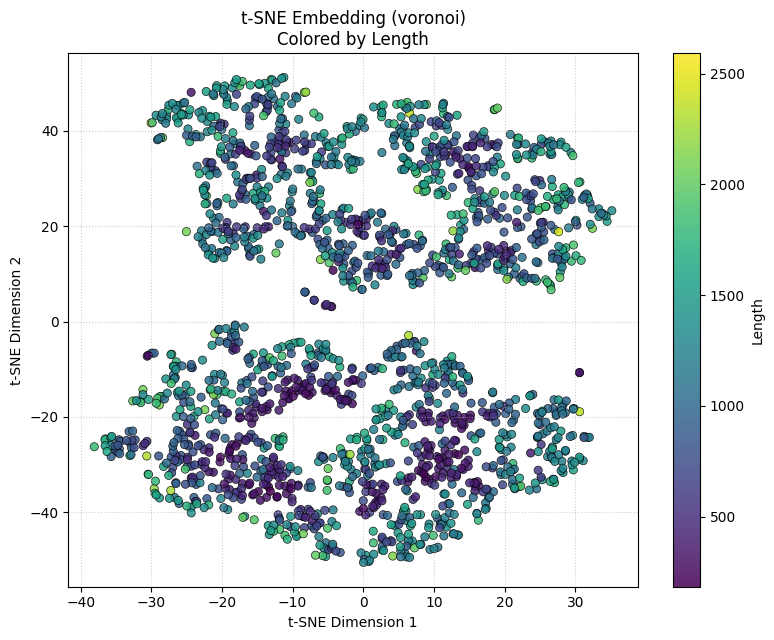

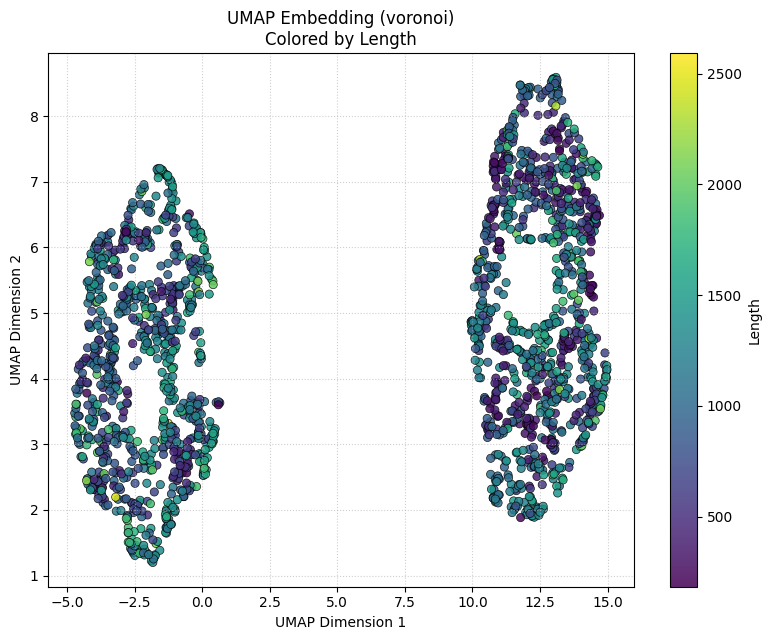


-- Plotting for 'deltaX' --


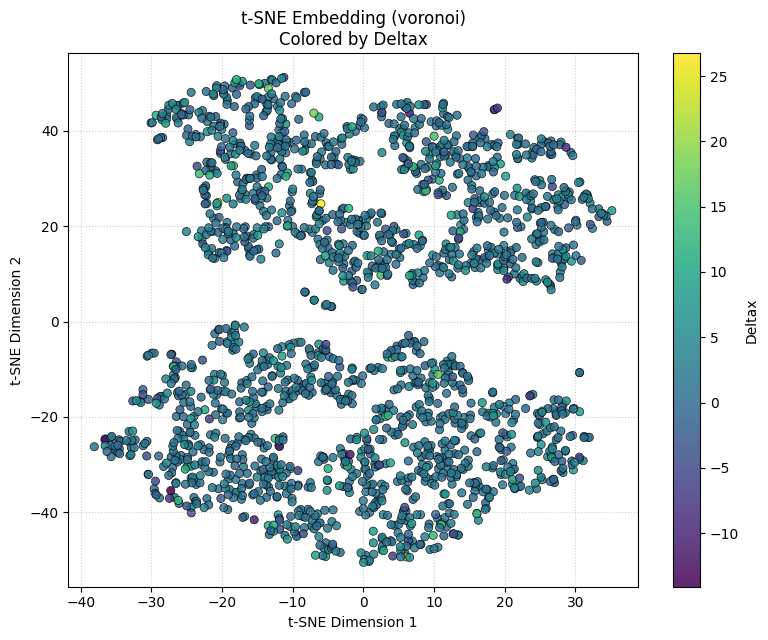

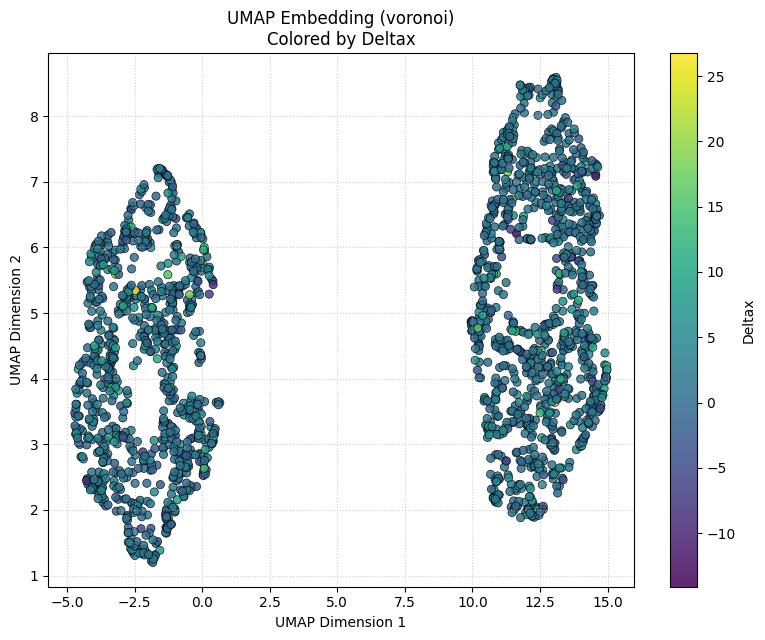


-- Plotting for 'speed_entropy' --


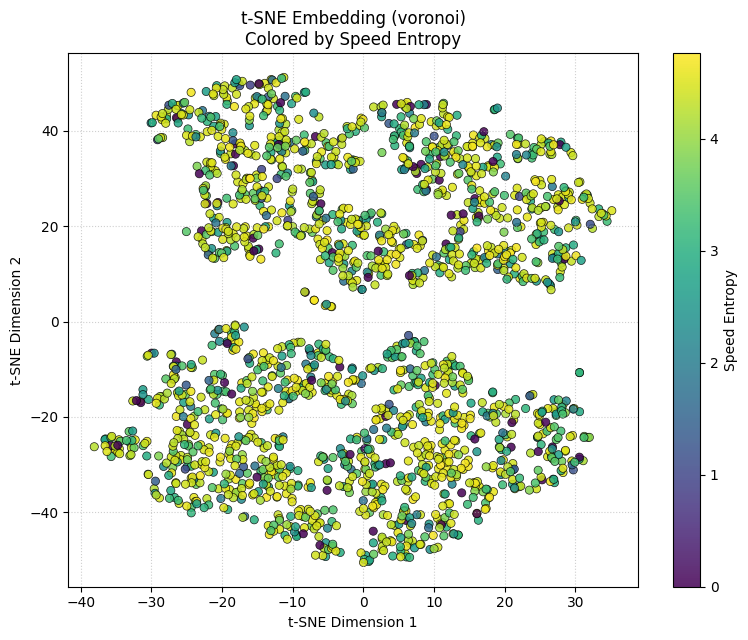

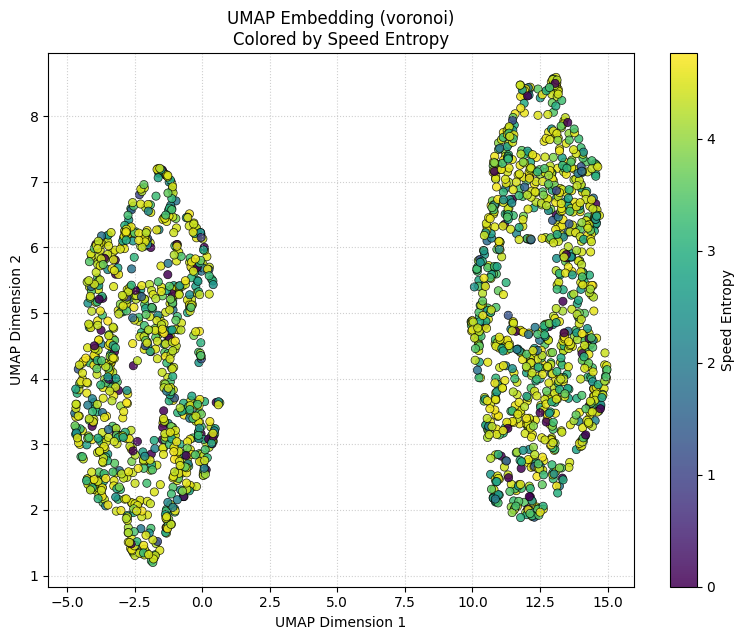


-- Plotting for 'acceleration_entropy' --


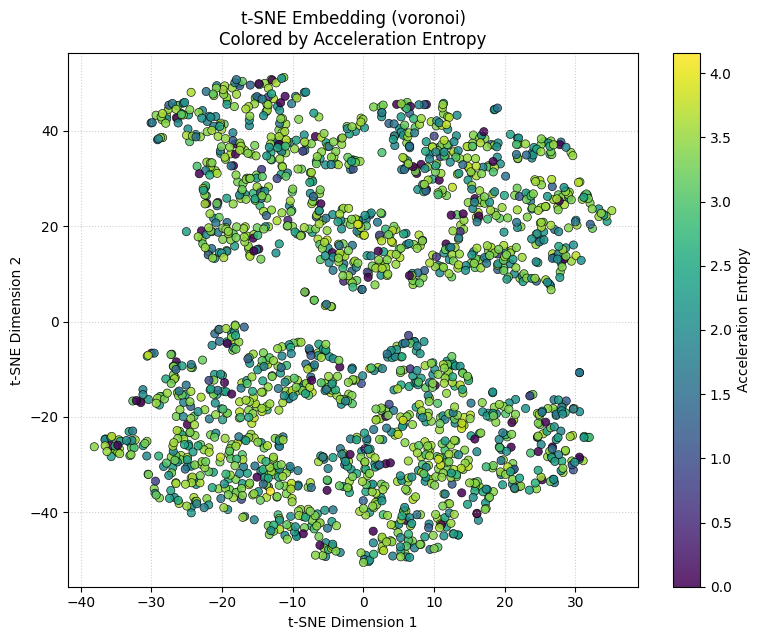

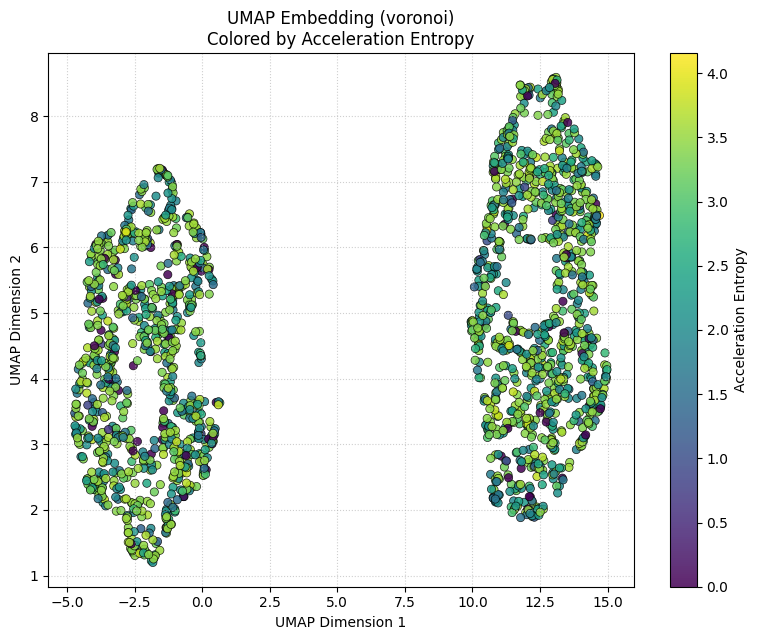


-- Plotting for 'curvature_entropy' --


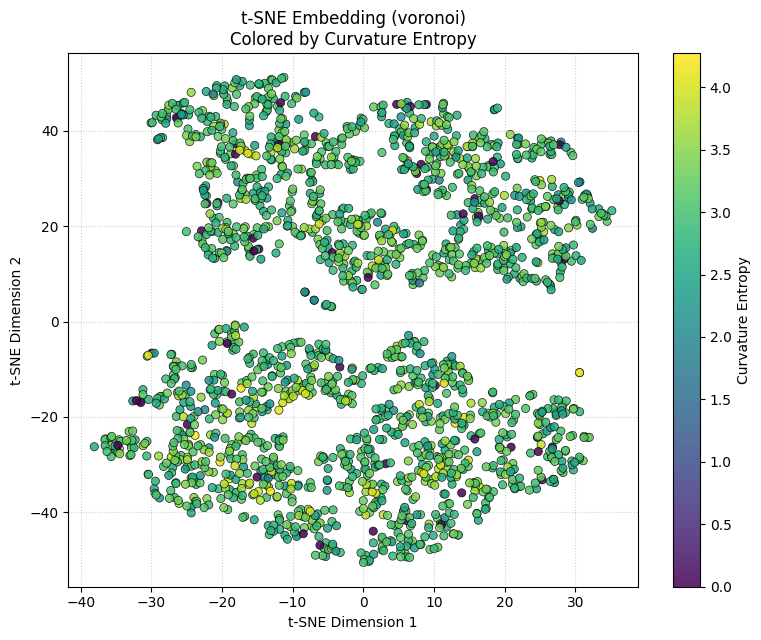

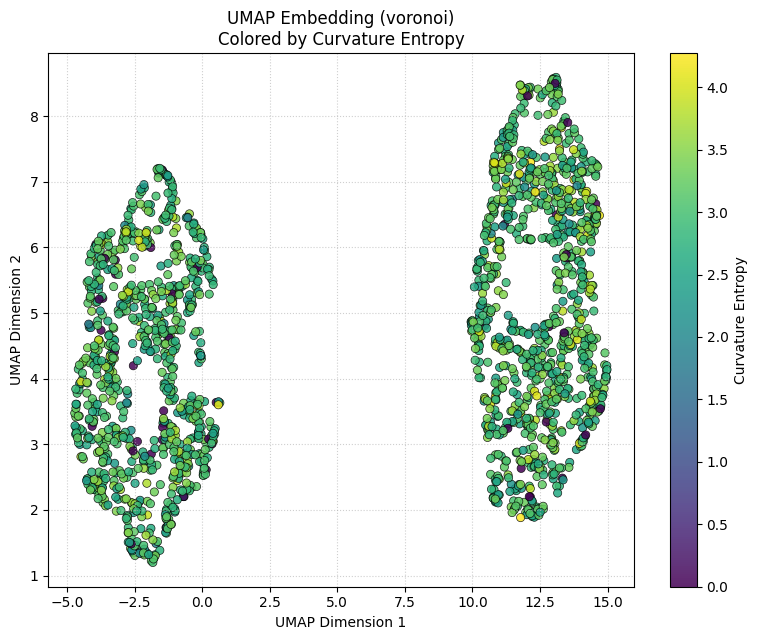


-- Plotting for 'avg_radius_mean' --


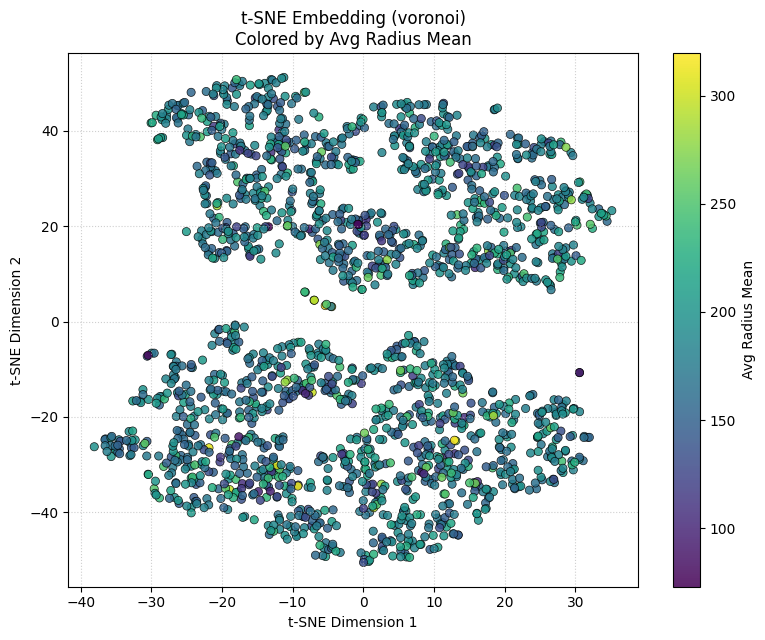

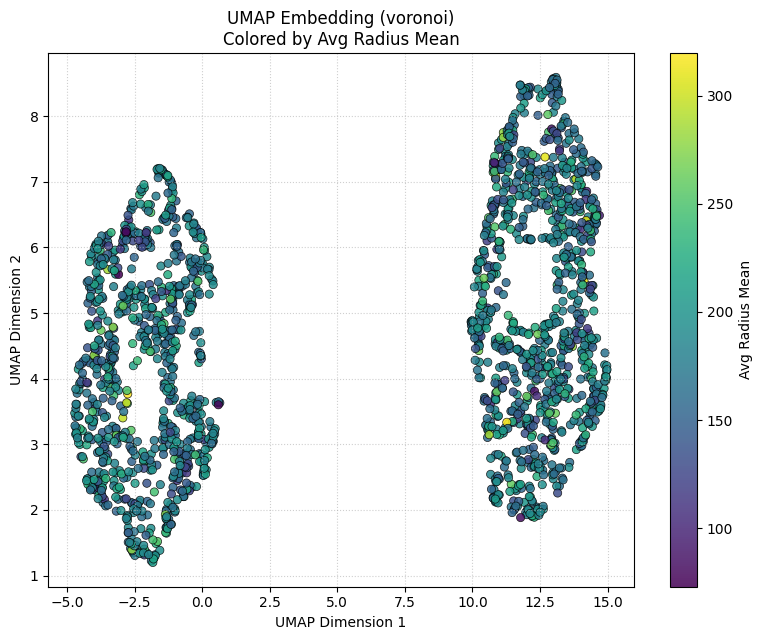


-- Plotting for 'right_bends' --


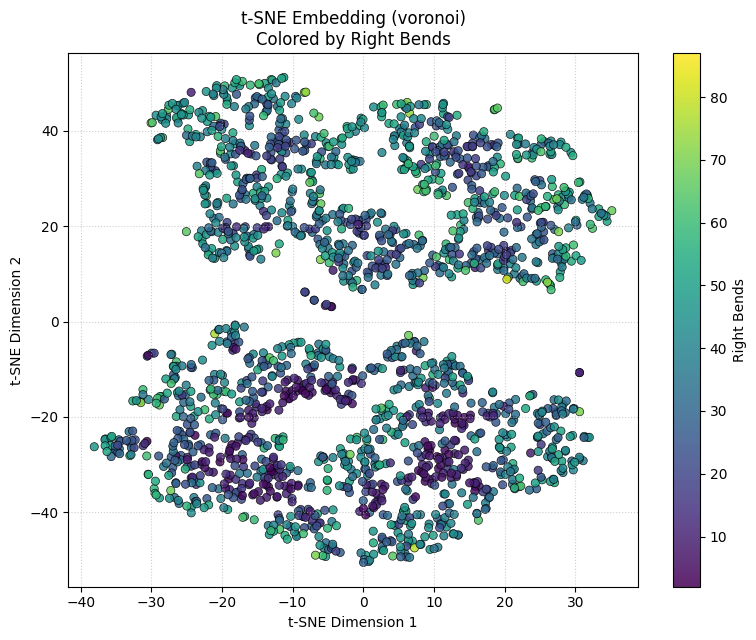

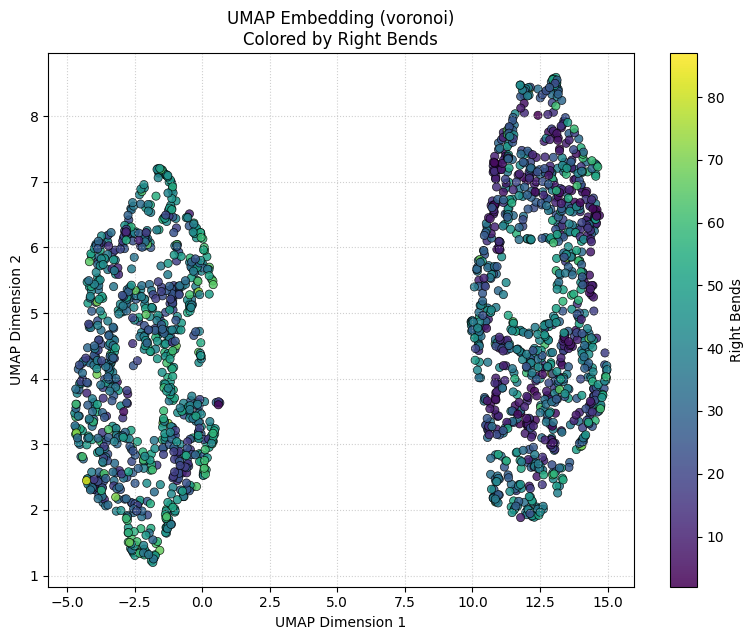


-- Plotting for 'total_overtakes' --


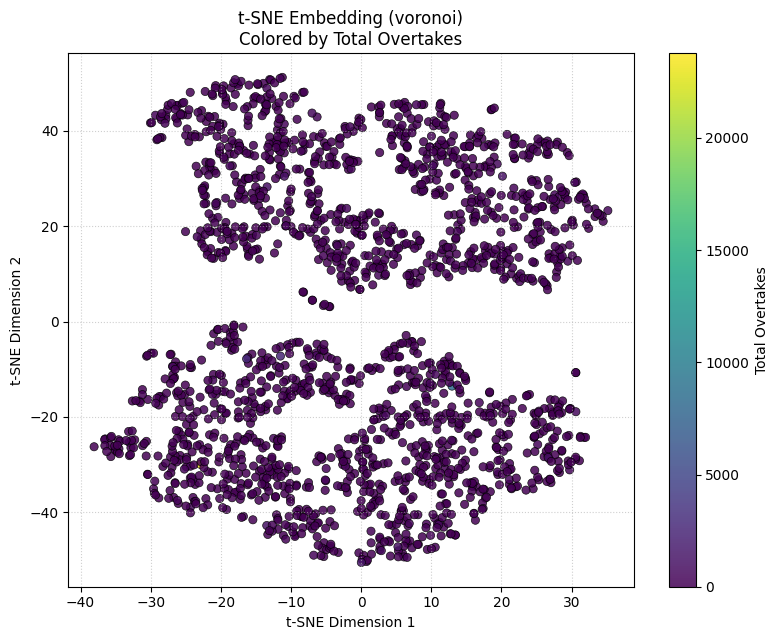

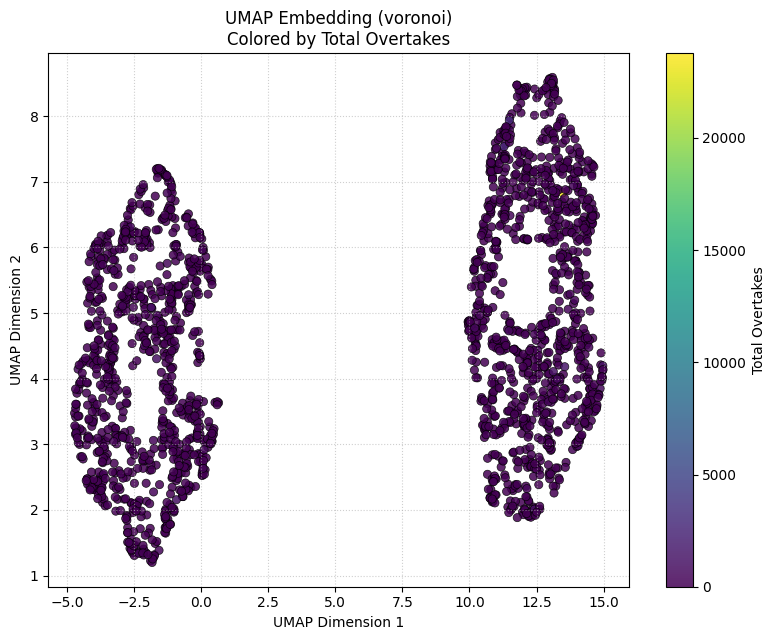

In [55]:
metrics_to_plot = [
    'length',              
    'deltaX',              
    'speed_entropy',      
    'acceleration_entropy',
    'curvature_entropy', 
    'avg_radius_mean',   
    'right_bends',      
    'total_overtakes'  
]

print(f"\n--- Generating Embedding Plots for Specified Metrics ---")
print(f"Attempting to plot for: {metrics_to_plot}")

# --- Check available data before plotting ---
can_plot_tsne = 'tsne_dim1' in df_embeddings_with_metrics.columns
can_plot_umap = 'umap_dim1' in df_embeddings_with_metrics.columns

# Find which of the *requested* metrics are *actually available* in the final DataFrame
available_metrics_in_df = [
    m for m in metrics_to_plot
    if m in df_embeddings_with_metrics.columns and m != 'seed'
]

# Also list ALL available metric columns in the final dataframe for user reference
all_available_metrics_in_df = [
    col for col in df_embeddings_with_metrics.columns
    if col not in ['seed', 'tsne_dim1', 'tsne_dim2', 'umap_dim1', 'umap_dim2'] # Exclude non-metric columns
]

print(f"\nMetrics specified in `metrics_to_plot`: {metrics_to_plot}")
print(f"Metrics AVAILABLE in the final DataFrame for plotting: {available_metrics_in_df}")
if not available_metrics_in_df and metrics_to_plot:
     print(f"  >> None of the specified metrics were found!")
     if all_available_metrics_in_df:
         print(f"  >> ALL available metric columns in the DataFrame are: {all_available_metrics_in_df}")
     else:
         print(f"  >> No metric columns were found in the final DataFrame.")


actual_plots_generated = 0

# --- Proceed with plotting only if conditions are met ---
if not (can_plot_tsne or can_plot_umap):
    print("\nCannot generate plots: No embedding coordinates (t-SNE or UMAP) are available.", file=sys.stderr)
elif df_embeddings_with_metrics.empty:
     print("\nCannot generate plots: The final DataFrame is empty.", file=sys.stderr)
elif not available_metrics_in_df: # Check if any of the requested metrics are actually available
     print("\nCannot generate plots: None of the metrics specified in `metrics_to_plot` were found in the final DataFrame.", file=sys.stderr)
     if all_available_metrics_in_df:
          print(f"  Consider using metrics from this list instead: {all_available_metrics_in_df}")
else:
    # Iterate ONLY through the metrics that are confirmed to be available
    print(f"\nGenerating plots for available metrics: {available_metrics_in_df}")
    for metric_name in available_metrics_in_df:

        print(f"\n-- Plotting for '{metric_name}' --")
        plotted_for_metric = False

        # Plot t-SNE if available
        if can_plot_tsne:
            plot_embedding_colored_by_metric(
                embedding_df=df_embeddings_with_metrics,
                x_col='tsne_dim1', y_col='tsne_dim2', metric_col=metric_name,
                technique_name=TECHNIQUE_NAME, embedding_type='t-SNE'
            )
            plotted_for_metric = True

        # Plot UMAP if available
        if can_plot_umap:
             plot_embedding_colored_by_metric(
                embedding_df=df_embeddings_with_metrics,
                x_col='umap_dim1', y_col='umap_dim2', metric_col=metric_name,
                technique_name=TECHNIQUE_NAME, embedding_type='UMAP'
             )
             plotted_for_metric = True

        if plotted_for_metric:
             actual_plots_generated += 1 # Count metrics plotted

    # Final summary message
    if actual_plots_generated == 0 and available_metrics_in_df: # Should not happen if logic is correct
         print("\nError: No plots were generated despite available metrics and coordinates.", file=sys.stderr)



# Comparing neighbours

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import random

# -----------------------------------------------------------------------------
# Public: show a random track and its nearest neighbor
# -----------------------------------------------------------------------------

def show_random_neighbor(df, embedding):
    seeds = df['seed'].dropna().astype(int).tolist()
    if not seeds:
        return
    ref_seed = random.choice(seeds)
    ref_idx = df.index[df['seed'] == ref_seed][0]
    dists = cdist(embedding[ref_idx:ref_idx+1], embedding)[0]
    nn_idx = int(np.argsort(dists)[1])
    nn_seed = int(df.at[nn_idx, 'seed'])
    splines = [global_original_splines.get(ref_seed, []),
               global_original_splines.get(nn_seed, [])]
    _plot_seeds(splines, [ref_seed, nn_seed],
                f"Nearest neighbor (ref seed: {ref_seed})")

# -----------------------------------------------------------------------------
# Internal: fixed-scale plot with seed titles
# -----------------------------------------------------------------------------

def _plot_seeds(splines, seeds, header):
    count = len(splines)
    if count != 2:
        return
    fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))
    half = 0.5
    # gather all points for centering
    all_pts = [(p['x'], p['y']) for sp in splines for p in sp if isinstance(p, dict)]
    if not all_pts:
        return
    xs, ys = zip(*all_pts)
    cx, cy = np.mean(xs), np.mean(ys)

    for ax, sp, seed in zip(axes, splines, seeds):
        pts = [(p['x'], p['y']) for p in sp if isinstance(p, dict)]
        if pts:
            x, y = zip(*pts)
            ax.plot(x, y, marker='.', linestyle='-', markersize=2, linewidth=1)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(cx - half, cx + half)
        ax.set_ylim(cy - half, cy + half)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.grid(True, linestyle=':', alpha=0.5)
        ax.set_title(f"Seed: {seed}", fontsize=9)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

    fig.suptitle(header, fontsize=11, y=0.98)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()


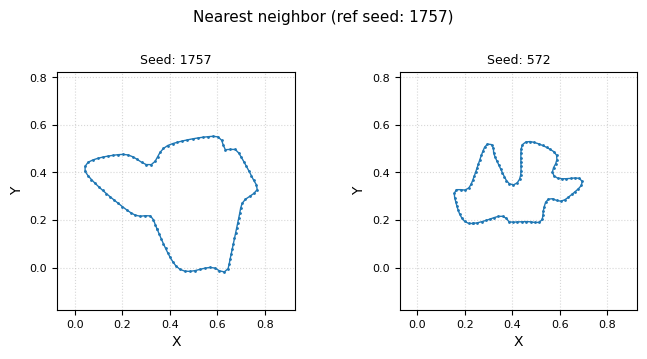

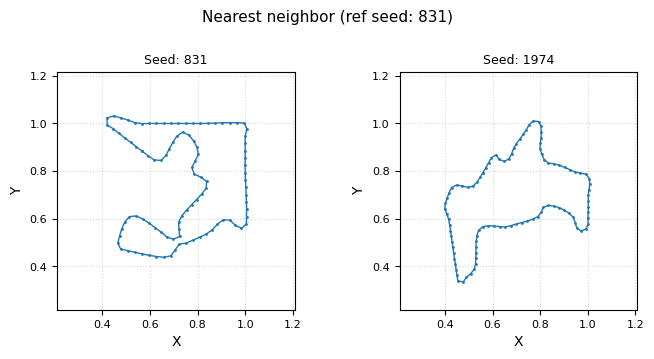

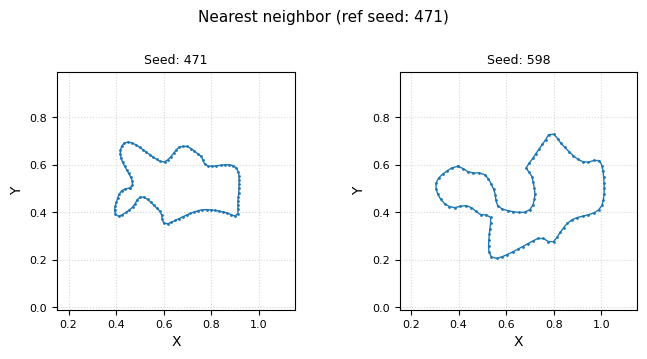

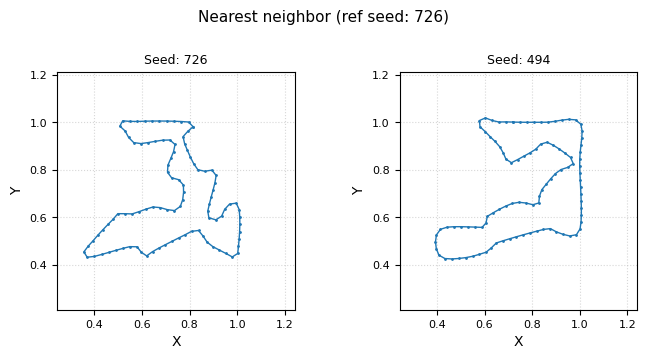

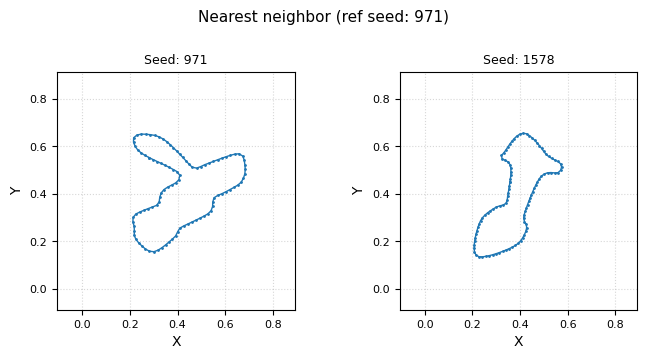

In [79]:
for i in range(5):
    show_random_neighbor(df_embeddings_with_metrics, umap_embedding)
